In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames[:2]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/lib/kaggle/gcp.py
/kaggle/input/daconfgsd/sample_submission.csv
/kaggle/input/daconfgsd/test.csv
/kaggle/input/daconfgsd/test/641.png
/kaggle/input/daconfgsd/test/173.png
/kaggle/input/daconfgsd/train/가구수정/11.png
/kaggle/input/daconfgsd/train/가구수정/4.png
/kaggle/input/daconfgsd/train/터짐/94.png
/kaggle/input/daconfgsd/train/터짐/48.png
/kaggle/input/daconfgsd/train/들뜸/48.png
/kaggle/input/daconfgsd/train/들뜸/37.png
/kaggle/input/daconfgsd/train/피스/48.png
/kaggle/input/daconfgsd/train/피스/37.png
/kaggle/input/daconfgsd/train/창틀,문틀수정/11.png
/kaggle/input/daconfgsd/train/창틀,문틀수정/4.png
/kaggle/input/daconfgsd/train/녹오염/11.png
/kaggle/input/daconfgsd/train/녹오염/4.png
/kaggle/input/daconfgsd/train/석고수정/48.png
/kaggle/input/daconfgsd/train/석고수정/37.png
/kaggle/input/daconfgsd/train/훼손/1231.png
/kaggle/input/daconfgsd/train/훼손/1017.png
/kaggle/input/daconfgsd/train/꼬임/173.png
/kaggle/input/daconfgsd/train/꼬임/94.png
/kaggle/input/daconfgsd/train/울음/11.png
/kaggle/input/daconfgsd/train/울음/4.png


In [47]:
from PIL import Image
import cv2
import albumentations as A
from tqdm import tqdm
import glob


train = pd.DataFrame({'path':glob.glob('/kaggle/input/daconfgsd/train/*/*')})
test = pd.read_csv('/kaggle/input/daconfgsd/test.csv')
# label = []
# path = []
# for dirname, _, filenames in os.walk('/kaggle/input/daconfgsd/train/'):
#     for filename in filenames[:]:
#         label.append(dirname.split('/')[-1])
#         path.append(os.path.join(dirname, filename))
        
# train = pd.DataFrame({'label':label, 'path':path})
# train.label.value_counts()

In [48]:
train['label'] = train['path'].apply(lambda x : x.split('/')[-2])
train

,path,label
0,/kaggle/input/daconfgsd/train/가구수정/11.png,가구수정
1,/kaggle/input/daconfgsd/train/가구수정/4.png,가구수정
2,/kaggle/input/daconfgsd/train/가구수정/9.png,가구수정
3,/kaggle/input/daconfgsd/train/가구수정/1.png,가구수정
4,/kaggle/input/daconfgsd/train/가구수정/2.png,가구수정
...,...,...
3452,/kaggle/input/daconfgsd/train/몰딩수정/19.png,몰딩수정
3453,/kaggle/input/daconfgsd/train/몰딩수정/110.png,몰딩수정
3454,/kaggle/input/daconfgsd/train/몰딩수정/26.png,몰딩수정
3455,/kaggle/input/daconfgsd/train/몰딩수정/79.png,몰딩수정


In [59]:
for path in tqdm(train["path"]):
    image = cv2.imread(path)
    image = cv2.resize(image, dsize=(300, 300))
    cv2.imwrite(path, image)
    
    

100%|██████████| 3457/3457 [00:41<00:00, 84.14it/s]


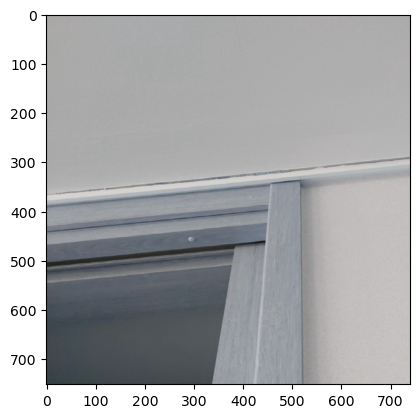

In [75]:
import matplotlib.pyplot as plt
# plt.imshow(cv2.imread('/kaggle/input/daconfgsd/train/몰딩수정/42.png'))
# plt.show()
plt.imshow(cv2.imread(path))
plt.show()

In [50]:
test['img_path'] = test['img_path'].apply(lambda x : x[1:])
test['img_path'] = '/kaggle/input/daconfgsd' + test['img_path']
test

,id,img_path
0,TEST_000,/kaggle/input/daconfgsd/test/000.png
1,TEST_001,/kaggle/input/daconfgsd/test/001.png
2,TEST_002,/kaggle/input/daconfgsd/test/002.png
3,TEST_003,/kaggle/input/daconfgsd/test/003.png
4,TEST_004,/kaggle/input/daconfgsd/test/004.png
...,...,...
787,TEST_787,/kaggle/input/daconfgsd/test/787.png
788,TEST_788,/kaggle/input/daconfgsd/test/788.png
789,TEST_789,/kaggle/input/daconfgsd/test/789.png
790,TEST_790,/kaggle/input/daconfgsd/test/790.png


## Image Augmentation
- 석고수정, 들뜸, 피스 &rarr; 2배
- 창틀,문틀수정, 울음, 이음부불량, 녹오염 가구수정 &rarr; 3배
- 틈새과다, 반점 &rarr; 5배
- vertical flip, horizontal flip, rotation, resize (300,300)

In [51]:
two_list = ["석고수정", "들뜸" ,'피스']
os.makedirs('train_300_2', exist_ok=True)

for category in two_list:
    for path in tqdm(train[train['label']==category]['path']):
        for i in range(2):
            name = path.split('/')[-1]
            image = cv2.imread(path)
            aug = A.Compose([A.VerticalFlip(), A.Rotate(p=1), A.HorizontalFlip(), A.Resize(300,300)])
            image_aug = aug(image=image)['image']
            cv2.imwrite('train_300_2/' + str(i) + category + name, image_aug)  ### augmentation 2번 시행할 때 'i'로 구분하지 않으면 덮어씌어짐
    
    
three_list = ["창틀,문틀수정","울음","이음부불량","녹오염",'가구수정']
os.makedirs('train_300_3', exist_ok=True)

for category in three_list:
    for path in tqdm(train[train['label']==category]['path']):
        for i in range(3):
            name = path.split('/')[-1]
            image = cv2.imread(path)
            aug = A.Compose([A.VerticalFlip(), A.Rotate(p=1), A.HorizontalFlip(), A.Resize(300,300)])
            image_aug = aug(image=image)['image']
            cv2.imwrite('train_300_3/' + str(i) + category + name, image_aug)
    
    
five_list = ["틈새과다",'반점']
os.makedirs('train_300_5', exist_ok=True)

for category in five_list:
    for path in tqdm(train[train['label']==category]['path']):
        for i in range(5):
            name = path.split('/')[-1]
            image = cv2.imread(path)
            aug = A.Compose([A.VerticalFlip(), A.Rotate(p=1), A.HorizontalFlip(), A.Resize(300,300)])
            image_aug = aug(image=image)['image']
            cv2.imwrite('train_300_5/' + str(i) + category + name, image_aug)

100%|██████████| 3/3 [00:00<00:00,  8.93it/s]


In [52]:
import re

glob.glob('/kaggle/working/*/*')
train_aug = pd.DataFrame({'path':glob.glob('/kaggle/working/*/*')})
train_aug['label'] = train_aug['path'].apply(lambda x: x.split('/')[-1].split('.')[0]).apply(lambda x: re.sub(r"[0-9]","",x))
train_aug

,path,label
0,/kaggle/working/train_300_5/2틈새과다1.png,틈새과다
1,/kaggle/working/train_300_5/2틈새과다0.png,틈새과다
2,/kaggle/working/train_300_5/1반점1.png,반점
3,/kaggle/working/train_300_5/0반점2.png,반점
4,/kaggle/working/train_300_5/3틈새과다0.png,틈새과다
...,...,...
635,/kaggle/working/train_300_2/1석고수정1.png,석고수정
636,/kaggle/working/train_300_2/1피스4.png,피스
637,/kaggle/working/train_300_2/0석고수정39.png,석고수정
638,/kaggle/working/train_300_2/0석고수정10.png,석고수정


In [53]:
train = pd.concat([train,train_aug], axis=0)  # 중복실행 X
train

,path,label
0,/kaggle/input/daconfgsd/train/가구수정/11.png,가구수정
1,/kaggle/input/daconfgsd/train/가구수정/4.png,가구수정
2,/kaggle/input/daconfgsd/train/가구수정/9.png,가구수정
3,/kaggle/input/daconfgsd/train/가구수정/1.png,가구수정
4,/kaggle/input/daconfgsd/train/가구수정/2.png,가구수정
...,...,...
3452,/kaggle/input/daconfgsd/train/몰딩수정/19.png,몰딩수정
3453,/kaggle/input/daconfgsd/train/몰딩수정/110.png,몰딩수정
3454,/kaggle/input/daconfgsd/train/몰딩수정/26.png,몰딩수정
3455,/kaggle/input/daconfgsd/train/몰딩수정/79.png,몰딩수정


## Train & Prediction
- Cross Validation & Ensembling
- Test-Time Augmentation(TTA) : test data를 augmentation하여 추론 &rarr; prediction에 반영

In [54]:
from sklearn.model_selection import StratifiedKFold, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.callbacks import *


skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
#kf = KFold(n_splits=10, random_state=42,shuffle=True)
result = 0
result2 = 0
for train_idx,valid_idx in skf.split(train,train['label']):
    x_train = train.iloc[train_idx]
    x_valid = train.iloc[valid_idx]
        
    es = EarlyStopping(patience = 4,restore_best_weights=True)
    rl = ReduceLROnPlateau(patience = 2,verbose=1)
    
    idg = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)   ## Test-Time Augmentation (TTA) 수직,수평 뒤집기
    idg2 = ImageDataGenerator()
    
    train_generator = idg.flow_from_dataframe(x_train, x_col = 'path',
                                              y_col = 'label',batch_size=32,target_size=(300,300)) # aug Plus
    valid_generator = idg2.flow_from_dataframe(x_valid, x_col = 'path',
                                               y_col = 'label',batch_size=32,target_size=(300,300)) # aug No
    test_generator = idg.flow_from_dataframe(test, x_col = 'img_path',y_col = None, batch_size=32,
                                             class_mode = None, shuffle=False,target_size=(300,300))    
    test_generator2 = idg2.flow_from_dataframe(test, x_col = 'img_path',y_col = None, batch_size=32, 
                                               class_mode = None, shuffle=False,target_size=(300,300))    
    
    # 모델 선언
    model = Sequential()
    model.add(EfficientNetB4(include_top=False, pooling='avg'))
    model.add(Dense(19, activation='softmax'))
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='acc')
    model.fit(train_generator, validation_data=valid_generator, epochs=20, callbacks=[es,rl])    
    
    
    # 예측 : TTA 30%, 일반추론 70%씩 반영
    result += model.predict(test_generator)/3 # 30%
    result2 += model.predict(test_generator2)/3 # 70%
    
final_result = 0.3*result + 0.7*result2

Found 2304 validated image filenames belonging to 19 classes.
Found 1153 validated image filenames belonging to 19 classes.
Found 792 validated image filenames.
Found 792 validated image filenames.
Epoch 1/20


2023-04-25 14:20:34.632399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1/72 [..............................] - ETA: 1:22:52 - loss: 3.0120 - acc: 0.0938

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_7/efficientnetb4/block2a_expand_bn/FusedBatchNormGradV3' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_24/3422385968.py", line 38, in <module>
      model.fit(train_generator, validation_data=valid_generator, epochs=20, callbacks=[es,rl])
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/sequential_7/efficientnetb4/block2a_expand_bn/FusedBatchNormGradV3'
OOM when allocating tensor with shape[32,144,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_7/efficientnetb4/block2a_expand_bn/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_632096]

In [ ]:
label_dict = {key:val for key,val in zip(train_generator.classes, x_train.label.tolist())}
prediction = np.argmax(final_result,axis=1)
prediction = np.vectorize(label_dict.get)(prediction)
prediction

In [45]:
sub = pd.read_csv('/kaggle/input/daconfgsd/sample_submission.csv')
sub['label'] = prediction
sub.to_csv('sub.csv', index=False)